In [18]:
import sys
sys.path.append('../FOLDER_2022_03_23_FOR_PAPER/')
sys.path.append('../david/')

import numpy as np
import matplotlib.pyplot as plt
import glob
import skimage


#image analysis
import sys
import os

import cv2

import pandas as pd
import skimage.io
from alienlab.improcessing import normalize, grey_to_rgb, make_binary
import alienlab.segment
from alienlab.fo import FramesOperator
import alienlab.io
import glob
from alienlab.regression_func import *
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects
import tqdm

import imageio
import itertools

from function_figures import *
import process_data

import alienlab.plot
p = alienlab.plot.PlotFigure()
p.save_folder = "../notebooks/images/may/bio_validation"
p.fontsize=18
p.fonttick=12
p.date = False
p.extension = ".pdf"

def init_image(file_path):
    frames_full = skimage.io.imread(file_path)

    #frames_full = np.stack([frames_full[:,:,1]]*10, 0) 
    #uncomment this line if you have a single RGB image. The [:,:,1] stands for selection of the green channel

    FO = FramesOperator(frames_full)
    im = normalize(FO.frames[0], 0, 1)
    im = grey_to_rgb(im)*255
    FO.compute_stats()

    # CROP
    #y, x = alienlab.io.select_roi(np.uint8(im)) #select area of interest

    FO.x = 100, 800
    FO.y = 100, 800
    #FO.crop() #crop image
    return FO


def segment_image(FO, contrast, autolevel, dist_max, dist_seg, disk_size, max_contrast, interact = True, showit = False):
    
    start_time = time.time()
    FO.selected_inds = np.linspace(250, 2050, 91).astype(int)

    
    def make_mask(contrast, autolevel, dist_max, dist_seg, disk_size, max_contrast, soft_hard_contrast, soft_hard_autolevel):
        #apply contrast filter to all frames
        frames_contrast = FO.apply(skimage.filters.rank.enhance_contrast,  selem = skimage.morphology.disk(contrast))
        #apply autolevel filter to all frames
        frames_autolevel = FO.apply(skimage.filters.rank.autolevel, selem = skimage.morphology.disk(autolevel))
        #sum the contrast images to get a reference grey-level contrast image
        frame_contrast = np.sum(frames_contrast, axis = 0)
        #sum the autolevel images to get a reference grey-level autolevel image
        frame_autolevel = np.sum(frames_autolevel, axis = 0)
        #obtain contrast mask from reference contrast image
        mask_contrast = make_binary(frame_contrast, soft_hard = soft_hard_contrast)
        #otbain autolevel mask from reference autolevel image
        mask_autolevel =  make_binary(frame_autolevel, soft_hard = soft_hard_autolevel)
        #intersection of contrast aud autolevel masks
        mask_intersect = mask_contrast * mask_autolevel
        #clean the masks with a binary opening
        mask_intersect = skimage.morphology.binary_opening(mask_intersect, selem = skimage.morphology.disk(disk_size))
        #mask_intersect = skimage.morphology.binary_erosion(mask_intersect, selem = skimage.morphology.disk(disk_size))

        #reference image of altitude for the watershed
        auto_contrast = normalize(mask_intersect * frame_autolevel)
        print("--- Computed binary mask in %04f seconds ---" % (time.time() - start_time))

        p.cmap = "inferno"
        if showit:
            p.figsize = (20,8)
            p.title_list =  'contrast', 'contrast threshold', 'mask intersect','autolevel', 'autolevel threshold','segmentation image'
            p.col_num = 3
            fig = p.multi([frame_contrast, mask_contrast, mask_intersect, 
                           frame_autolevel, mask_autolevel,  auto_contrast])
            p.save_name = 'Segmentation reference'
            p.saving(fig)
            
        return auto_contrast, mask_intersect
    auto_contrast, mask_intersect = make_mask(contrast, autolevel, dist_max, dist_seg, disk_size, max_contrast, soft_hard_contrast = 1, soft_hard_autolevel = 1)
    ref, mask = make_mask(contrast, autolevel, dist_max, dist_seg, disk_size, max_contrast, soft_hard_contrast = 0.3, soft_hard_autolevel = 0.5)

    start_time = time.time()

    #locate the local maxima
    local_maxi = alienlab.segment.local_maxima(auto_contrast, max_contrast, p,
                                                     ref_distance = dist_max, mask = mask_intersect, show = showit)
    #perform watershed segmentation
    watershed_im_mask = alienlab.segment.watershed(ref*mask_intersect, mask , local_maxi,
                                                         p, ref_distance = dist_seg, show = True)
    segmented = watershed_im_mask
    print("--- Computed segmentation in %04f seconds ---" % (time.time() - start_time))

    if showit:
        alienlab.segment.show_segmentation(FO, segmented, p)
        
    if interact == False:
       return watershed_im_mask, FO    

list_y = []

for folder in glob.glob(folder_ref + "*qE_calib*"):
    label =  os.path.split(glob.glob(folder_ref + "*qE_calib*")[i])[1]

    if 'WT222' not in label and "CC124" not in label:
        print(label)
        file = glob.glob(folder + "/video.tiff")[0]
        video = skimage.io.imread(file)
        mask = video[250]>40
        #plt.imshow(mask)
        y = video.reshape(video.shape[0], -1)[:,mask.flatten()]
        y = y/y[250]
        list_y.append(y)
        plt.plot(y)

2023-01-10_11_49_WT4_qE_calib_0
2023-01-11_11_54_WT4_qE_calib_0
2023-01-17_11_23_WT4_qE_calib_0
2023-01-10_18_06_WT4_qE_calib_1
2023-01-11_18_12_WT4_qE_calib_1
2023-01-17_16_59_WT4_qE_calib_1
2023-01-10_12_25_qE_calib_0
2023-01-11_12_30_qE_calib_0
2023-01-17_11_59_qE_calib_0
2023-01-10_18_42_qE_calib_1
2023-01-11_18_48_qE_calib_1
2023-01-17_17_35_qE_calib_1


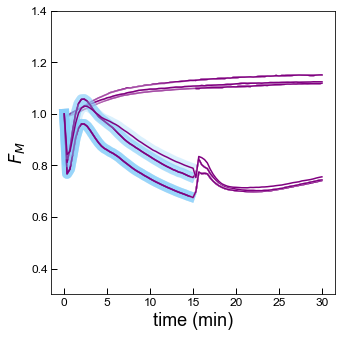

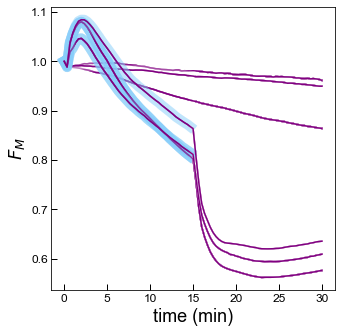

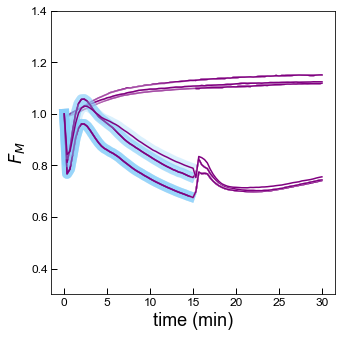

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [40]:
folder_ref = "G:/DREAM/from_github/PAMFluo/Experiments/FOLDER_2022_12_14_SP_check/"
p.ylabel ="$F_M$"
p.xlabel = "time (min)"

fig0 = p.set_figure("%d", "%0.1f")
ax0 = plt.gca()

fig1 = p.set_figure("%d", "%0.1f")
ax1 = plt.gca()

ax = {"calib_0":ax0, "calib_1":ax1}

for j, F in enumerate([folder_ref + "dark/", folder_ref + "blue/"]):

    for k, calib in enumerate(['calib_0', 'calib_1']):
        list_y = []

        plt.ylim(0.3, 1.4)

        for i, folder in enumerate(glob.glob(F + "*qE_calib*")):
            label =  os.path.split(glob.glob(F + "*qE_calib*")[i])[1]

            if 'WT222' not in label and "CC124" not in label and calib in label:
                print(label)
                file =np.load(glob.glob(folder + "/items_dict.npy")[0], allow_pickle=True).item()
                y_loc = []
                if len(file.keys()) == 6:
                    file = file["items_dict"]
                for algae in file.keys():
                    if file[algae]["surface"] > 40:
                        y = file[algae]['mean']

                        y = y[250::20]/y[250]
                        x = np.linspace(0, len(y)-1, len(y))*20/60 #1 pulse every 20s
                        #plt.plot(x, y, color =["cadetblue", "seagreen"][k], alpha = 0.4)
                        y_loc.append(y)
                list_y.append(np.mean(y_loc, axis = 0))

            for i, y in enumerate(list_y):
                ax[calib].plot(x[0:45], y[0:45], color = ["white", "lightskyblue"][j], linewidth = 10, alpha  = 0.3)
                ax[calib].plot(x[44:], y[44:], color = ["white", "white"][j])
                ax[calib].plot(x, y, color = "purple", )

p.save_name = "SP_check_calib_0"
p.saving(fig0)

p.save_name = "SP_check_calib_1"
p.saving(fig1)
            #plt.plot(y)

In [ ]:
p.set_figure("%d", "%0.1f")
plt.ylim(0.3, 1.4)
for i, y in enumerate(list_y):

            if "calib_0" in label:
                #plt.plot(y[y>10]/y[250], "k", label = label )
                plt.plot(y[250::20], 'k')
                #plt.legend()
plt.ylim(0, 1.5)

plt.xlabel("pulse")
plt.ylabel("FM")

In [ ]:
list_y = []
"""
for folder in glob.glob("*qE_calib*"):
    file = glob.glob(folder + "/video.tiff")[0]
    
    FO = init_image(file)
    p.save_folder= folder
    watershed_im_mask, FO    = segment_image(FO, contrast = 6, autolevel = 5, dist_max = True, dist_seg=True, disk_size = 1, max_contrast = 3, interact = False, showit= True)  
    np.save(folder + "/labels.npy", watershed_im_mask)
    
"""

In [ ]:
list_pair2 = np.array([250, 270, 290, 1130, 1250, 1350, 1450, 1730, 2050])

couples = list(itertools.combinations(list_pair2, 2))

method = "combine4"


@delayed
@wrap_non_picklable_objects
def get_ratio_from_video(start_vid, F0, F1, mask_flat):
        video = imageio.get_reader(start_vid)
        frame_250 = video.get_data(250)
        frame_F0 = video.get_data(F0)
        frame_F1 = video.get_data(F1)
        r0  = (frame_250 - frame_F0)/frame_F0
        r1 = (frame_250 - frame_F1)/frame_F1
        diff = r1-r0
        diff = np.nan_to_num(diff, neginf=0, nan=0, posinf=0) 
        return diff.flatten()[mask_flat!=0]
    
def transform_data(data, transform):
    #print(data.shape, transform.shape)
    #data = (data - M_lda.T)/S_lda.T
    XT = np.dot(data, transform.T)
    return XT

x, y = 0,1

fig1, ax1 = create_ellipse(method, [purple, orange, green], x, y, id_list, Z, lims)


for folder in glob.glob("G:/DREAM/from_github/PAMFluo/Experiments/FOLDER_2022_12_14_SP_check/dark/*qE_calib*"):
    
    if "WT4_qE_calib_1" in folder:

        labels = glob.glob(folder + "/labels.npy")[0]

        mask = np.load(labels)

        mask_flat = mask.flatten()

        transforms = []

        diffs = []


        video = glob.glob(folder + "/video.tiff")[0]

        diff = Parallel(n_jobs = -1 )(get_ratio_from_video(video, couple[0], couple[1], mask_flat) for couple in tqdm.tqdm(couples))
        diff = np.array(diff)
        diffs.append(diff)
        diffs = np.array(diffs)

        diff_labels = []
        for label in tqdm.tqdm(np.unique(mask)):
            s = np.sum(mask==label)
            if label !=0 and s>5:# and s<60:
                diff_labels.append(np.mean(diffs[:,:,mask_flat[mask_flat!=0]==label], axis = -1))

        diff_labels = np.array(diff_labels)
        diff_labels.shape


        RTr = pd.read_csv("../data/combine4_array_RTr.csv", sep = " ", header = None)
        M_lda = np.array(pd.read_csv("../data/combine4_array_M_lda.csv",  sep = " ", header = None))
        S_lda = np.array(pd.read_csv("../data/combine4_array_S_lda.csv",  sep = " ", header = None))




        compare  = []
        for j, i in enumerate(range(0,1)):
            arr = diff_labels[:,i,:]
            #u = transform_data((arr-M_lda.T)/S_lda.T, RTr)
            u = transform_data(arr, RTr)

            #u = transform_data(arr, RTr)
            Xc, Yc =  u[:,0], u[:,1]
            Xc, Yc = clip_xy(u[:,x], u[:,y])
            ax1.plot(Xc, Yc, ".", label = os.path.split(folder)[1])#, color = ["darkorange","goldenrod"][j], alpha = 0.5)
            compare.append(u)
#plt.legend()

p.save_name = 'SP_effect/compare_points_%s_%d'%("SP", 1)
u = p.saving(fig1)


In [ ]:

for folder in glob.glob("G:/DREAM/from_github/PAMFluo/Experiments/FOLDER_2022_12_14_SP_check/*qE_calib*"):
    
    if "WT4_qE_calib_1" in folder:

        labels = glob.glob(folder + "/labels.npy")[0]

        mask = np.load(labels)

        mask_flat = mask.flatten()

        transforms = []

        diffs = []


        video = glob.glob(folder + "/video.tiff")[0]

        diff = Parallel(n_jobs = -1 )(get_ratio_from_video(video, couple[0], couple[1], mask_flat) for couple in tqdm.tqdm(couples))
        diff = np.array(diff)
        diffs.append(diff)
        diffs = np.array(diffs)

        diff_labels = []
        for label in tqdm.tqdm(np.unique(mask)):
            s = np.sum(mask==label)
            if label !=0 and s>5:# and s<60:
                diff_labels.append(np.mean(diffs[:,:,mask_flat[mask_flat!=0]==label], axis = -1))

        diff_labels = np.array(diff_labels)
        diff_labels.shape


        RTr = pd.read_csv("../data/combine4_array_RTr.csv", sep = " ", header = None)
        M_lda = np.array(pd.read_csv("../data/combine4_array_M_lda.csv",  sep = " ", header = None))
        S_lda = np.array(pd.read_csv("../data/combine4_array_S_lda.csv",  sep = " ", header = None))




        compare  = []
        for j, i in enumerate(range(0,1)):
            arr = diff_labels[:,i,:]
            #u = transform_data((arr-M_lda.T)/S_lda.T, RTr)
            u = transform_data(arr, RTr)

            #u = transform_data(arr, RTr)
            Xc, Yc =  u[:,0], u[:,1]
            Xc, Yc = clip_xy(u[:,x], u[:,y])
            ax1.plot(Xc, Yc, ".", label = os.path.split(folder)[1])#, color = ["darkorange","goldenrod"][j], alpha = 0.5)
            compare.append(u)
#plt.legend()

p.save_name = 'SP_effect/compare_points_%s_%d'%("SP", 1)
u = p.saving(fig1)
w

## Dictionary

In [ ]:
for folder in glob.glob("G:/DREAM/from_github/PAMFluo/Experiments/FOLDER_2022_12_14_SP_check/*qE_calib*"):
    file = glob.glob(folder + "/video.tiff")[0]
    
    labels = glob.glob(folder + "/labels.npy")[0]

    segmented = np.load(labels)
    FO = init_image(file)
    
    items = np.unique(segmented) #returns the set of values in items, corresponds to the values of the markers of local_maxima

    items_dict = {}
    for k in items:
        key = str(k)
        items_dict[key] = {}
        x_coords, y_coords = np.nonzero(segmented == k)
        items_dict[key]['x_coords'] = x_coords
        items_dict[key]['y_coords'] = y_coords
        pixel_values = FO.frames[:,x_coords, y_coords]
        items_dict[key]['pixel_values'] = pixel_values
        items_dict[key]['surface'] = pixel_values.shape[1]
        items_dict[key]['mean'] = np.mean(pixel_values, axis = 1)
        items_dict[key]['std'] = np.std(pixel_values, axis = 1)
        items_dict[key]['remains'] = True
        
    np.save(folder + "/items_dict.npy", items)

##### HERE COMPUTE

In [ ]:
projs.shape

In [ ]:
method = 'dict'
x, y = 0,2
fig1, ax1 = create_ellipse(method, [purple, orange, green], x, y, id_list, Z, lims)

for folder in glob.glob("G:/DREAM/from_github/PAMFluo/Experiments/FOLDER_2022_12_14_SP_check/*qE_calib*")[10:-1]:
    
    color = 'w'
    if "WT4_qE_calib_1" in folder:
        color = "k"
    elif  "WT4_qE_calib_0" in folder:
        color = "darkolivegreen"
        print("yo")
    if color != 'w':
        projs = []
        items_dict = np.load(folder + "/items_dict.npy", allow_pickle = True).item()
        one_exp = []
        for k in items_dict.keys(): 
            pulses = items_dict[k]['mean']
            pos = np.linspace(250, 2050, 91).astype(int)
            pulses = pulses[pos]
            pulses = pulses/pulses[0]
            one_exp.append(pulses)
        one_exp = np.array(one_exp) 
        proj_pulse = process_data.make_transforms(one_exp, "../david/data/to_alien/")
        projs.append(proj_pulse)
            
        projs = np.array(projs)
        plt.plot(projs[:,:,x], projs[:,:,y], '.', color = color)
        
p.save_name = "SP_check_%d_%d"%(x,y)
u = p.saving(fig1)




In [ ]:
def transform_data(data, dict_learner, transform):
    #data = data/data[:,0:1]
    data = data/np.sum(data, axis = 1)
    #data = (data - M_dict)/S_dict
    data = dict_learner.transform(data)
    data = (data - M_lda.T)/S_lda.T
    XT = np.dot(data, transform.T)
    return XT



with open("../data/dico.pkl", "rb") as file:
    dict_learner = pk.load(file)
    
M_dict = np.array(pd.read_csv("../data/dict_array_M_dict.csv",  sep = " ", header = None))
S_dict = np.array(pd.read_csv("../data/dict_array_S_dict.csv",  sep = " ", header = None))

RTr = pd.read_csv("../data/dict_array_RTr.csv", sep = " ", header = None)
M_lda = np.array(pd.read_csv("../data/dict_array_M_lda.csv",  sep = " ", header = None))
S_lda = np.array(pd.read_csv("../data/dict_array_S_lda.csv",  sep = " ", header = None))

method = 'dict'
x, y = 0,2

fig1, ax1 = create_ellipse(method, [purple, orange, green], x, y, id_list, Z, lims)


for folder in glob.glob("G:/DREAM/from_github/PAMFluo/Experiments/FOLDER_2022_12_14_SP_check/*qE_calib*")[25:40]:
    
    if "WT4_qE_calib_1" in folder:
        print("yo")
        projs = []
        items_dict = np.load(folder + "/items_dict.npy", allow_pickle = True).item()
        for k in items_dict.keys(): 
            pulses = items_dict[k]['mean']
            pos = np.linspace(250, 2050, 91).astype(int)
            pulses = pulses[pos]
            
            proj_pulse = transform_data(np.expand_dims(pulses,0), dict_learner, RTr)
            projs.append(proj_pulse)
            
        projs = np.array(projs)
        plt.scatter(projs[:,0,x], projs[:,0,y])

In [ ]:
 X_hat = X_transformed @ dict_learner.components_

In [ ]:
np.sum(np.expand_dims(pulses,0), axis = 1)